### Denoising using Scaterring Covariance

This notebook provides a simplified example of how to use scattering covariance to distinguish between noise and the signal of interest. The observational data model $d$ is given by: 

$d = s + n$. 

In this context, $s$ is represented by a 2D smiley picture and $n$ is white noise. We assume there are $n_{noise}=100$ noise realizations. We define two loss functions: 

$L_1 = \sum_{n_{noise}}{\frac{{(\Phi(d)-\Phi(s+n))}^2}{\sigma_{n}^2}}$, 

and 

$L_2 = \sum_{n_{noise}}{\frac{{(\Phi(d,s)-\Phi(s+n,s))}^2}{\sigma_{x}^2}}$.

Given that noise-induced biases are related to the signal of interest, the algorithm employs two iteration types. The first type minimizes the $L_1$ and $L_2$ losses to produce a signal model $s*$. The second type, termed an epoch to avoid confusion, updates the definition of $s*$, where $s*$ is initially $d$ and subsequently is the retrieved $s$ from the prior epoch. Consequently, $\sigma_{n}$ is the standard deviation of $\Phi(s*+n)-\Phi(s*)$, and $\sigma_{x}$ is the standard deviation of $\Phi(s*+n,s*)-\Phi(s*,s*)$.

#Call the foscat library
!pip install foscat==3.2.0

In [1]:
import numpy as np
import os, sys
import matplotlib.pyplot as plt
import foscat.Synthesis as synthe

## Initialize data

The signal of interest is a 2D smiley picture downgraded to xsize=64 to make it run faster. The value range is [0,1].

In [2]:
xsize=64
# number of noise to learn statistics
nnoise=10

# amplitude of the white noise
ampnoise=0.3

# Load the smiley picture

([], [])

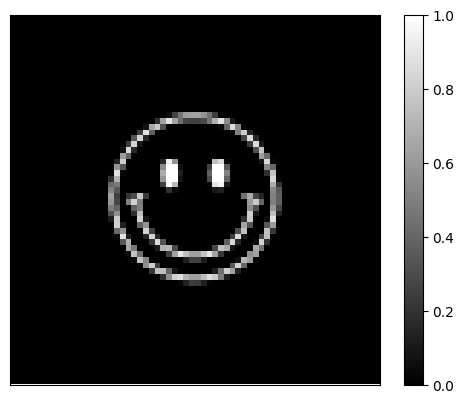

In [3]:
from PIL import Image

SMILEY_IMAGE = '/mnt/d/sauvepctel/smiley-face-svg-rogne.jpg'
img = Image.open(SMILEY_IMAGE)
smiley=np.zeros([512,512])
smiley[256-128:256+128,256-128:256+128] = 1.0*(np.asarray(img)[:,:,0]<128)

# de zoom at the xsize scale
smiley=np.sum(np.sum(smiley.reshape(xsize,512//xsize,xsize,512//xsize),3),1)/(512/xsize)**2
plt.imshow(smiley,cmap='gray')
plt.colorbar()
plt.xticks([])
plt.yticks([])

# compute noise population

In [4]:
noise=ampnoise*np.random.randn(nnoise,xsize,xsize)

# Define the Scaterring Covariance statistics

In [5]:
import foscat.scat_cov2D as sc
print('Work with ScatCov')

scat_op=sc.funct()

Work with ScatCov


In [ ]:
r=scat

## define the statistics

the eval_scat function defines how the statistics are computed using foscat.

In [6]:
def eval_scat(sc,x,image2=None,mask=None):
    return sc.eval(x,image2=image2,mask=mask).flatten()

In [7]:
# compute statistics for the smiley and the smiley+noise

ref=scat_op.eval(smiley)
nref=scat_op.eval(smiley+noise[0])

Text(0.5, 1.0, 'Measured data')

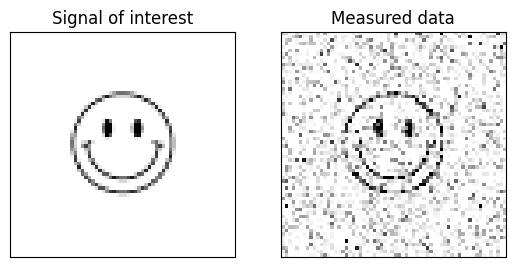

In [8]:

# shows both pictures

plt.subplot(1,2,1)
plt.imshow(smiley,vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Signal of interest')
plt.subplot(1,2,2)
plt.imshow(smiley+noise[0],vmin=0,vmax=1,cmap='Grays')
plt.xticks([])
plt.yticks([])
plt.title('Measured data')

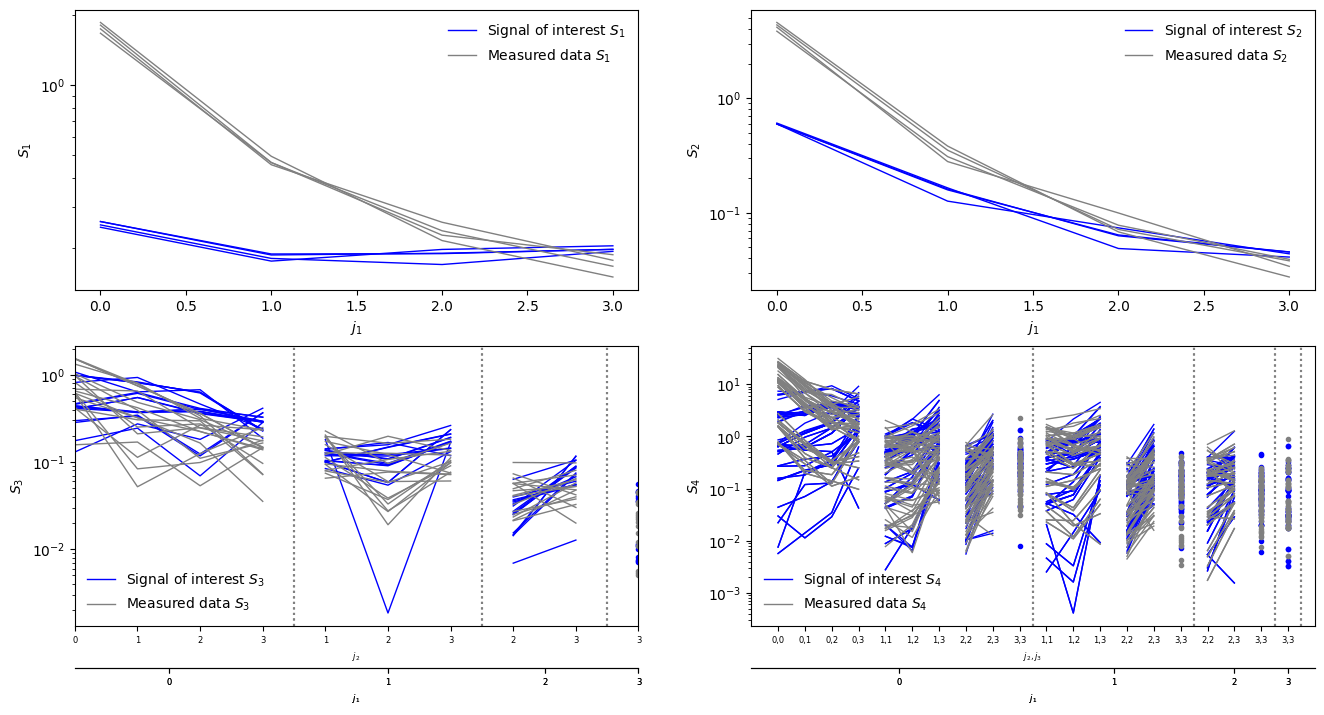

In [9]:
# show both statistics

ref.plot(name='Signal of interest')
nref.plot(hold=False,color='grey',name='Measured data')

# Start the statistical cleanning

We define here an image to be cleaned called *im* and at the first epoch *imref*=*im* to compute the bias and the statistics.

In [10]:
#=================================================================================
# DEFINE The LOSS FUNCTION AND THE SYNTHESIS
#=================================================================================

# \Phi(d) \simeq \Phi(u + n),
def The_loss_1(x,scat_operator,args,return_all=False):

    ref  = args[0]
    bref = args[1]
    vref = args[2]
    im   = args[3]

    learn=eval_scat(scat_operator,im-x)+bref
    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/vref))

    return(loss)

# \Phi(u,d) \simeq \Phi(u,u+n),
def The_loss_2(x,scat_operator,args,return_all=False):

    bref = args[0]
    vref = args[1]
    im   = args[2]

    learn=eval_scat(scat_operator,im-x,image2=im)
    ref=eval_scat(scat_operator,im-x,image2=im-x)+bref
    loss=scat_operator.reduce_mean(scat_operator.square((ref-learn)/vref))

    return(loss)

In [11]:
im = smiley+ampnoise*np.random.randn(xsize,xsize)

imref=im.copy()

# compute the statistics for the two losses
tref=eval_scat(scat_op,imref)
cref=eval_scat(scat_op,imref,image2=imref)

tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
for k in range(nnoise):
    tmp1[k]=scat_op.backend.to_numpy((eval_scat(scat_op,imref+noise[k])-tref)[0])
    tmp2[k]=scat_op.backend.to_numpy((eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0])

In [12]:
# compute the bias and sigma related to the noise and imref of the given epoch
bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

In [13]:
# compute the observe statistics
ref1=eval_scat(scat_op,im)

In [14]:
#=================================================================================
# DEFINE The LOSS FUNCTION AND THE SYNTHESIS
#=================================================================================

# \Phi(d) \simeq \Phi(u + n),
def The_loss_1(x,scat_operator,args,return_all=False):

    ref  = args[0]
    bref = args[1]
    vref = args[2]
    im   = args[3]

    learn=eval_scat(scat_operator,im-x)+bref
    tmp=(learn-ref)/vref
    print(tmp.shape)
    loss=scat_operator.backend.bk_reduce_sum(scat_operator.square(tmp),1)
    print(loss.shape)
    return(scat_operator.backend.bk_min(loss))

# \Phi(u,d) \simeq \Phi(u,u+n),
def The_loss_2(x,scat_operator,args,return_all=False):

    bref = args[0]
    vref = args[1]
    im   = args[2]

    learn=eval_scat(scat_operator,im,image2=im-x)
    ref=eval_scat(scat_operator,im-x,image2=im-x)+bref
    tmp=(ref-learn)/vref
    loss=scat_operator.backend.bk_reduce_sum(scat_operator.square(tmp),1)
    
    return(scat_operator.backend.bk_min(loss))


# \Phi(u,d) \simeq \Phi(u,u+n),
def The_loss_3(x,scat_operator,args,return_all=False):

    xim = args[0]
    vref = args[1]
    im   = args[2]

    bref=scat_operator.backend.bk_complex(x[0],x[1])
    learn=eval_scat(scat_operator,im,image2=im-xim)
    ref=eval_scat(scat_operator,im-xim,image2=im-xim)+bref
    tmp=(ref-learn)/vref
    loss=scat_operator.backend.bk_reduce_sum(scat_operator.square(tmp),1)
    
    return(scat_operator.backend.bk_min(loss))

In [16]:
nnoise=30

d=smiley+ampnoise*np.random.randn(xsize,xsize)
all_noise=ampnoise*np.random.randn(nnoise,xsize,xsize)

ref=eval_scat(scat_op,d)

model=eval_scat(scat_op,smiley,image2=smiley)
popu=np.tile((smiley).flatten(),nnoise).reshape(nnoise,xsize,xsize)
nmodel=eval_scat(scat_op,popu+all_noise,image2=popu)

bias=(nmodel-model)
vbias=np.std(scat_op.backend.to_numpy(bias))+0J
im=d

In [19]:
# constant information within all epochs
c_im = d
v_bias_2=bias[0]
v_sigma_2=vbias
v_noise=np.random.randn(xsize,xsize)

loss2=synthe.Loss(The_loss_2,scat_op,v_bias_2,v_sigma_2,c_im)
# define the foscat synthesis using the two previous loss
sy1 = synthe.Synthesis([loss2])
loss3=synthe.Loss(The_loss_3,scat_op,v_noise,v_sigma_2,c_im)
# define the foscat synthesis using the two previous loss
sy2 = synthe.Synthesis([loss3])

In [21]:
imap=np.random.randn(xsize,xsize)*1E-6
vvvbias_r=np.std(scat_op.backend.to_numpy(bias.numpy()).real,0)
vvvbias_i=np.std(scat_op.backend.to_numpy(bias.numpy()).imag,0)
lmax=1E3
icorr=np.median(bias,0)
for itt in range(1000):
    np.random.seed(itt)
    if itt!=0:
        corr=scat_op.backend.bk_complex(0.01*np.random.randn(bias.shape[1])*vvvbias_r,
                                        0.01*np.random.randn(bias.shape[1])*vvvbias_i)
    else:
        corr=0.0
        
    v_bias_2.assign(icorr+corr)   
    
    omap=sy1.run(scat_op.backend.bk_cast(imap),
                    EVAL_FREQUENCY=200,
                    NUM_EPOCHS = 100)
    floss=np.min(sy1.get_history())
    if floss<lmax:
        icorr=icorr+corr
        lmax=floss
        a=np.std(im-smiley)
        b=np.std(im-smiley-omap)
        print("Input noise Level %.3f, Output noise Level %.3f, Gain ratio %.3f, Loss %.2f"%(a,b,a/b,floss))

TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

In [ ]:
print(sy2.get_history())

In [ ]:
# let's have a look after the first epoch
res=omap
def draw_pict(value,order,title,cmap='Greys'):
    plt.subplot(2,3,1+order)
    plt.title(title)
    plt.imshow(value,vmin=0,vmax=1,cmap=cmap)
    plt.xticks([])
    plt.yticks([])
    
plt.figure(figsize=(12,7))
draw_pict(smiley,0,'Model')
draw_pict(im,1,'Model+noise')
draw_pict(im-res,2,'Retrieved data')
draw_pict(im-smiley,3,'Noise')
draw_pict(res,4,'Retrieved noise')
draw_pict(res-(im-smiley),5,'Residual')
draw_pict(im-res,2,'Retrieve data')

a=np.std(im-smiley)
b=np.std(im-smiley-res)
print("Input noise Level %.3f, Output noise Level %.3f, Gain ratio %.2f"%(a,b,a/b))

In [ ]:
rbias=-(eval_scat(scat_op,smiley,image2=smiley)-eval_scat(scat_op,d,image2=smiley))

In [ ]:
distri=np.std((rbias-bias)/vbias,1)
imax=np.argmin(distri)
delta=rbias[0]-bias[imax]
ibias=10
ntest=100
loss=np.zeros([ntest])
ubias=bias[imax].numpy()
ubias=rbias[0].numpy().copy()
center=ubias[ibias]
for k in range(1):
    ubias=rbias[0].numpy().copy()+1/ntest*rbias[0].numpy().copy()*np.random.randn(rbias.shape[0])
    v_bias_2.assign(ubias)
    omap=sy.run(scat_op.backend.bk_cast(imap),
                    EVAL_FREQUENCY=100,
                    NUM_EPOCHS = 3000)
    loss[k]=np.min(sy.get_history())

In [ ]:
plt.plot(loss)
k

# declare the loss function used for the synthesis

Here is a small trick related to Tensorflow backend that avoid to recompute the graph at every epoch.

In [ ]:
# constant information within all epochs
c_ref1=scat_op.backend.backend.constant(ref1)
c_im = scat_op.backend.backend.constant(im)

# variable information within all epochs
v_bias_1=scat_op.backend.backend.Variable(bias_1)
v_sigma_1=scat_op.backend.backend.Variable(sigma_1)
v_bias_2=scat_op.backend.backend.Variable(bias_2)
v_sigma_2=scat_op.backend.backend.Variable(sigma_2)

#decle the loss class
loss1=synthe.Loss(The_loss_1,scat_op,c_ref1,v_bias_1,v_sigma_1,c_im)
loss2=synthe.Loss(The_loss_2,scat_op,v_bias_2,v_sigma_2,c_im)

# define the foscat synthesis using the two previous loss
sy = synthe.Synthesis([loss1,loss2])

In [ ]:
imap=np.random.randn(xsize,xsize)*1E-6
omap=sy.run(scat_op.backend.bk_cast(imap),
                            EVAL_FREQUENCY=50,
                            NUM_EPOCHS = 300)

In [ ]:
# let's have a look after the first epoch
res=omap.numpy().copy()
def draw_pict(value,order,title):
    plt.subplot(2,3,1+order)
    plt.title(title)
    plt.imshow(value,vmin=0,vmax=1,cmap='Greys')
    plt.xticks([])
    plt.yticks([])

plt.figure(figsize=(12,7))
draw_pict(smiley,0,'Model')
draw_pict(im,1,'Model+noise')
draw_pict(im-res,2,'Retrieved data')
draw_pict(im-smiley,3,'Noise')
draw_pict(res,4,'Retrieved noise')
draw_pict(res-(im-smiley),5,'Residual')
draw_pict(im-res,2,'Retrieve data')

a=np.std(im-smiley)
b=np.std(im-smiley-res)
print("Input noise Level %.3f, Output noise Level %.3f, Gain ratio %.2f"%(a,b,a/b))

# now run other epoch

In [ ]:
# prepare a list to store the result at each epoch
omap={}
omap[0]=res

nitt=3
for itt in range(nitt):
    imref=im-omap[itt]
    
    # compute the statistics for the two losses
    tref=eval_scat(scat_op,imref)
    cref=eval_scat(scat_op,imref,image2=imref)

    tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
    tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
    for k in range(nnoise):
        tmp1[k]=(eval_scat(scat_op,imref+noise[k])-tref)[0]
        tmp2[k]=(eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0]

    # compute the bias and sigma related to the noise and imref of the given epoch
    bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
    sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
    bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
    sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

    # assign new values for the minimisation
    v_bias_1.assign(bias_1)
    v_sigma_1.assign(sigma_1)
    v_bias_2.assign(bias_2)
    v_sigma_2.assign(sigma_2)

    # compute 
    imap=np.random.randn(xsize,xsize)*1E-6
    omap[itt+1]=sy.run(scat_op.backend.bk_cast(imap),
                                EVAL_FREQUENCY=50,
                                NUM_EPOCHS = 300)

    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt+1])
    print("Input noise Level %.2f, Output noise Level %.2f, Gain ratio %.2f"%(a,b,a/b))

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.title('Input Data')
plt.imshow(im,vmin=0,vmax=1,cmap='Greys')
plt.xticks([])
plt.yticks([])
for itt in range(nitt+1):
    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt])
    plt.subplot(1,5,2+itt)
    plt.title('Itteration #%d (%.2f)'%(itt,a/b))
    plt.imshow(im-omap[itt],vmin=0,vmax=1,cmap='Grays')
    plt.xticks([])
    plt.yticks([])

### Mask region to optimise the result

If the region where the signal of interest is known to be 0, it is possible to force the statistic using a mask while computing the SC biases and variance.

In [ ]:
# add a mask to the statistics, as we know that the smiley is at the center

x,y=np.meshgrid(np.arange(xsize)+0.5-xsize/2,np.arange(xsize)+0.5-xsize/2)
mask=(x*x+y*y)<(xsize/4)**2

# prepare a list to store the result at each epoch
omap={}
omap[0]=res

nitt=3
for itt in range(nitt):
    imref=(im-omap[itt])*mask
    
    # compute the statistics for the two losses
    tref=eval_scat(scat_op,imref)
    cref=eval_scat(scat_op,imref,image2=imref)

    tmp1=np.zeros([nnoise,tref.shape[1]],dtype='complex')
    tmp2=np.zeros([nnoise,cref.shape[1]],dtype='complex')
    for k in range(nnoise):
        tmp1[k]=(eval_scat(scat_op,imref+noise[k])-tref)[0]
        tmp2[k]=(eval_scat(scat_op,imref,image2=imref+noise[k])-cref)[0]

    # compute the bias and sigma related to the noise and imref of the given epoch
    bias_1=scat_op.backend.bk_cast(np.mean(tmp1,0))
    sigma_1=scat_op.backend.bk_cast(np.std(tmp1,0)+0J)
    bias_2=scat_op.backend.bk_cast(np.mean(tmp2,0))
    sigma_2=scat_op.backend.bk_cast(np.std(tmp2,0)+0J)

    # assign new values for the minimisation
    v_bias_1.assign(bias_1)
    v_sigma_1.assign(sigma_1)
    v_bias_2.assign(bias_2)
    v_sigma_2.assign(sigma_2)

    # compute 
    imap=np.random.randn(xsize,xsize)*1E-6
    omap[itt+1]=sy.run(scat_op.backend.bk_cast(imap),
                                EVAL_FREQUENCY=50,
                                NUM_EPOCHS = 300)

    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt+1])
    print("Input noise Level %.2f, Output noise Level %.2f, Gain ratio %.2f"%(a,b,a/b))

In [ ]:
plt.figure(figsize=(16,4))
plt.subplot(1,5,1)
plt.title('Input Data')
plt.imshow(im,vmin=0,vmax=1,cmap='Greys')
plt.xticks([])
plt.yticks([])
for itt in range(nitt+1):
    a=np.std(im-smiley)
    b=np.std(im-smiley-omap[itt])
    plt.subplot(1,5,2+itt)
    plt.title('Itteration #%d (%.2f)'%(itt,a/b))
    plt.imshow(im-omap[itt],vmin=0,vmax=1,cmap='Grays')
    plt.xticks([])
    plt.yticks([])